## EECS491 - A5
### Blind Source Separation
##### Tristan Maidment (tdm47)

#### Goal
The goal for this assignment is to implement the BSS algorithm by hand, and apply it on a mixed distribution of two independent waveforms.

#### Implementation
The first step is to import the wave files used in the demo.

In [1]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')
_, dataSpeech = wavfile.read('data/speech.wav')

In [2]:
import numpy as np


np.random.seed(519)

def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

Using these two data files and the normalization function, we can greate the ground truth waveforms.

In [3]:
gtruthS = audionorm((dataBach, dataSpeech))

The next step is to mix the independent distributions into a random multivariate distribution.  This can be done by specifying a mixing matrix that linearly modifies the shape of each distribution.

In [4]:
def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

def drawDataWithMixingMatrix(data, mat):
    # plot data points
    plt.scatter(data[0], data[1], s=1)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')

Using the defined functions, we can define a mixed distribution which simulates input from two different microphones. In addition, we can plot the true mixing matrix values on top to visualize the true disributions.

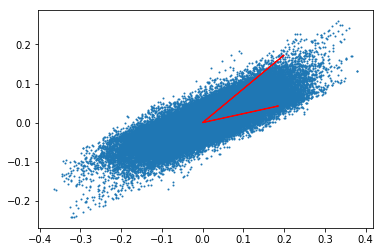

In [6]:
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

In [7]:
wavfile.write('data/mixedTrackA.wav', srate, X[0])
wavfile.write('data/mixedTrackB.wav', srate, X[1])

The **BSS** function works by defining a prior distribution, and fitting the A matrix so that this probablility of this data given this distribution is maximal.  For that reason, the a gradient descent is performed on matrix A, to find the mixing matrix that most optimally fits the data to the distribution.

A decently large step size is viable for simple distributions.

In [8]:
def bss(data, stop=1e-8, max_iter=1000, q=1, nu=0.5):
    sources, length = data.shape
    I = np.identity(sources)
    likelihood = 1

    A = np.identity(sources)
    
    for i in range(max_iter):
        if stop > likelihood:
            break
        s = np.linalg.inv(A) @ data
        A_grad = -A @ (d_logP(s, q) @ s.T + I)
        A += np.multiply(nu, A_grad)
        likelihood = np.mean(Pxa(s, A, q))
        if i % 10 == 0:
            print("iter", i, "log_likelihood", likelihood)
    return A/A.max(), np.linalg.inv(A) @ data 

def P(s, q):
    return np.exp(-np.power(np.abs(s),q))

def d_logP(s, q):
    return -np.divide(q * np.power(np.abs(s), q), s)

def Pxa(s, A, q):
    return P(s, q)/np.linalg.det(A)

Given synthentic laplacian data, the mixing matrix converges fairly quickly.  In addition, it very closely represents the original mixing matrix.

In [9]:
def syntheticDataGenerate(A, nsamples):
    S = np.random.laplace(size = (2,nsamples))
    # generate mixed audio data
    X = A @ S
    
    return X

In [10]:
# quantity of data points
nsamples = 10000
# specific mixing matrix (for illustration purpose)
verifyA = np.asarray([[-1, 1],[2, 2]])
# generate synthetic data
synthData = syntheticDataGenerate(verifyA, nsamples)
# do optimization with bss function
estimateA, recoverData = bss(synthData, stop=3e-11)

iter 0 log_likelihood 2.6782672527090025e-09
iter 10 log_likelihood 2.244977197876288e-09
iter 20 log_likelihood 2.251185373017958e-09
iter 30 log_likelihood 2.4028732373927254e-09
iter 40 log_likelihood 2.5302317333935646e-09
iter 50 log_likelihood 2.5306925770429683e-09
iter 60 log_likelihood 2.530692975664425e-09
iter 70 log_likelihood 2.5306927343513514e-09
iter 80 log_likelihood 2.530691717846208e-09
iter 90 log_likelihood 2.5306932122133224e-09
iter 100 log_likelihood 2.5306917412989548e-09
iter 110 log_likelihood 2.5306926630470355e-09
iter 120 log_likelihood 2.5306932124523797e-09
iter 130 log_likelihood 2.5306916961218015e-09
iter 140 log_likelihood 2.5306916707914066e-09
iter 150 log_likelihood 2.5306916760566965e-09
iter 160 log_likelihood 2.530694723280704e-09
iter 170 log_likelihood 2.530693044494684e-09
iter 180 log_likelihood 2.5306926700264617e-09
iter 190 log_likelihood 2.5306928286657313e-09
iter 200 log_likelihood 2.530691880687775e-09
iter 210 log_likelihood 2.53069

In [11]:
def compareMixingMatrix(data, matA, matB):
    plt.figure(figsize=(16, 8))
    # plot first mixing matrix
    plt.subplot(1,2,1)
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    plt.subplot(1,2,2)
    drawDataWithMixingMatrix(data, matB)

As we can see, the estimated mixing matrix very closely approximates the data.  Occasionally, it appears to be facing the wrong direction.  A simple explanation for this is that there is not enough equations to solve for all variables in the equation.  For this reason, the sign `+/-` is estimated, which respresents a "flipped" distribution.  This is represented by a vector facing the wrong direction.

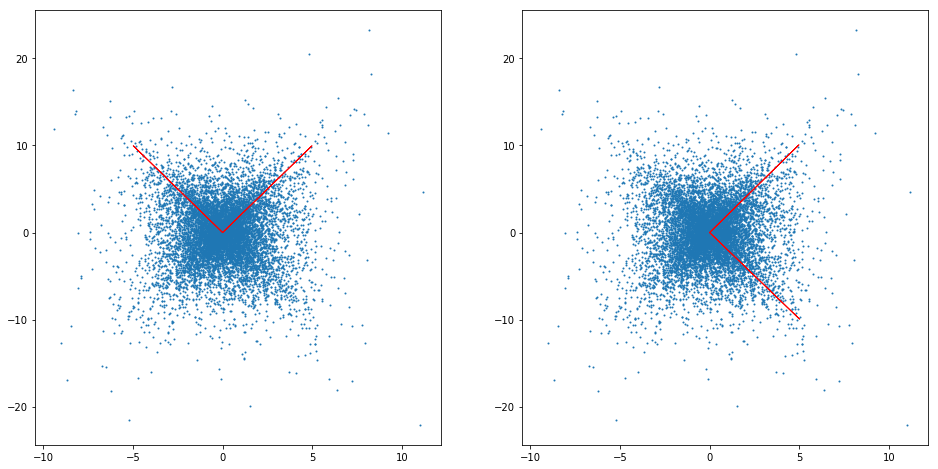

In [12]:
compareMixingMatrix(synthData, verifyA, estimateA)

In [13]:
A, S = bss(X)

iter 0 log_likelihood 4.356566627899329e-07
iter 10 log_likelihood 5.4422140628184185e-08
iter 20 log_likelihood 5.450134357536105e-08
iter 30 log_likelihood 5.450160310609339e-08
iter 40 log_likelihood 5.450160507612061e-08
iter 50 log_likelihood 5.450160513393923e-08
iter 60 log_likelihood 5.450160514224954e-08
iter 70 log_likelihood 5.4501605150431216e-08
iter 80 log_likelihood 5.450160515622421e-08
iter 90 log_likelihood 5.450160515181248e-08
iter 100 log_likelihood 5.4501605150288735e-08
iter 110 log_likelihood 5.45016051320158e-08
iter 120 log_likelihood 5.4501605134638756e-08
iter 130 log_likelihood 5.4501605143803255e-08
iter 140 log_likelihood 5.450160514853524e-08
iter 150 log_likelihood 5.4501605151324246e-08
iter 160 log_likelihood 5.450160515672103e-08
iter 170 log_likelihood 5.450160514683691e-08
iter 180 log_likelihood 5.450160515565112e-08
iter 190 log_likelihood 5.450160516385086e-08
iter 200 log_likelihood 5.450160512536174e-08
iter 210 log_likelihood 5.45016051329546

In [14]:
### normalized sound tracks
S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrackA.wav', 22050, S[0])
wavfile.write('data/separatedTrackB.wav', 22050, S[1])

I have not set a random seed for this notebook, to allow the functions to be run by other users.  As mentioned previously, the vectors (which represent the positive direction of the distributions) are ocassionally pointing the wrong direction, indicating a flipped distribution.

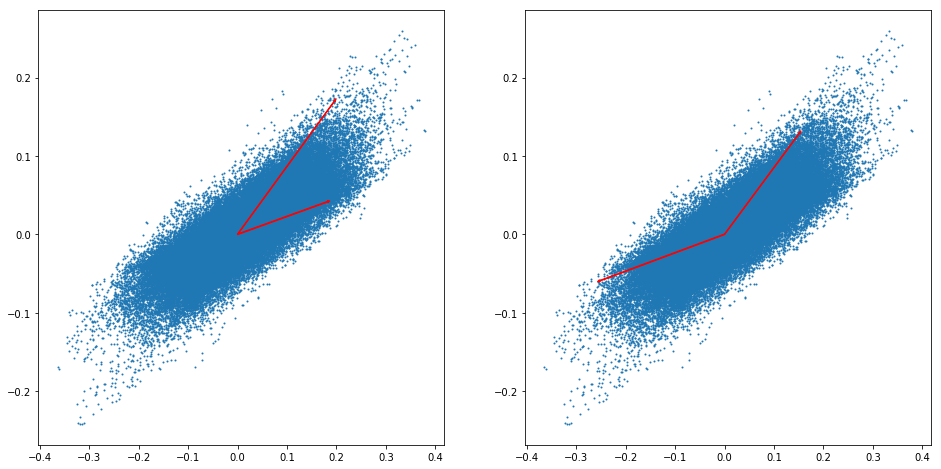

In [15]:
compareMixingMatrix(X, gtruthA, A) 

In [16]:
print('\nMixing Matrix (Our Estimation)\n\n', A)
print('\nMixing Matrix (Groud Truth)\n\n', gtruthA)


Mixing Matrix (Our Estimation)

 [[ 1.         -1.66824441]
 [ 0.85183554 -0.39164574]]

Mixing Matrix (Groud Truth)

 [[0.61847544 0.66618213]
 [0.14127466 0.57728887]]


We can output the distribution of the estimated signals.  The distributions are very laplacian, indicating that the maximization function worked as expected.

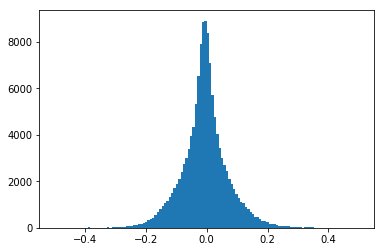

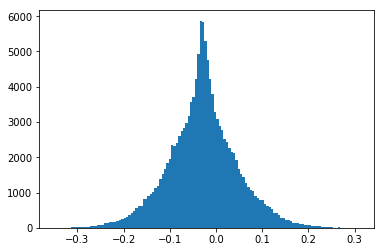

In [17]:
plt.hist(S[0], 128)
plt.show()
plt.hist(S[1], 128)
plt.show()

#### Full Unsupervised
BSS is technically considered an semi supervised algorithm due to the necessity to specify a prior distribution.  This is a limitation for real world applications of the algorithm since the distribution is generally unknown.

To fix this problem, we will calculate the log-likelihood of distributions of various `q` values.  In addition, we will be descending a set amount of steps for each `q`.  The values of `q` with the highest log-likelihood after the set amount of steps is the q that results in the smallest mixing matrix gradients.  This indicates that the model is converging faster.  As such, we will fit the data with the value of q that provides the smallest gradients, i.e. converges fastest, with the assumption that the distribution is best fit by this q.

This method is fully unsupervised.  However, it is not perfect for situations where certain distributions fit the mixed data better than the true prior distribution.  This will be explored when testing this method on the synthetic data.

In [18]:
def bss(data, max_iter=20, q=1, nu=0.5, max_grad=10, q_max = 4):
    sources, length = data.shape
    I = np.identity(sources)
    likelihood = np.zeros((q_max * 100))
    B = np.zeros((q_max * 100, sources, sources))
    q_range = np.arange(0, q_max, 0.01)
    for q in q_range:
        j = int(q * 100)
        A = np.identity(sources)
        for i in range(max_iter):
            s = np.linalg.inv(A) @ data
            A_grad = -A @ (d_logP(s, q + 0.01) @ s.T + I)

            A += np.multiply(nu, A_grad)
        likelihood[j] = np.mean(Pxa(s, A, q + 0.01))

        B[j,:,:] = A
        print("q", q + 0.01, "log_likelihood", likelihood[j])
    
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(q_range, likelihood)
    plt.ylim(likelihood.min(), likelihood.max())
    #ax.set_yscale('log')
    plt.show()
    print("q:", likelihood.argmax()/100)
    A = B[likelihood.argmax()]
    return A/A.max(), np.linalg.inv(A) @ data 

def P(s, q):
    return np.exp(-np.power(np.abs(s),q))

def d_logP(s, q):
    return -np.divide(q * np.power(np.abs(s), q), s)

def Pxa(s, A, q):
    #print("s", s, "A", A, "q", q)
    return P(s, q)/np.linalg.det(A)

#def d_logP_q(s, q):
#    return -np.power(np.abs(s), q) * np.log(np.abs(s))

def d_logP_q(s, q):
    A = np.log2(q/s.shape[1] * np.power(np.abs(np.subtract(s, np.mean(s))), q))
    B = q**2
    return np.divide(A, B)

As we can see, the optimal value for `q`, without any prior information, is `1.92`.  This isn't the best guess, as it assumes a gaussian distribution.  However, a multivariate laplace distribution is gaussian along the orthogonal direction, so this result is understandable.

q 0.01 log_likelihood 1.1430450056030994e-133
q 0.02 log_likelihood 1.4840687794086765e-130
q 0.03 log_likelihood 1.0506712011582158e-127
q 0.04 log_likelihood 1.3922545049682002e-123
q 0.05 log_likelihood -1.0869647724395937e-116
q 0.060000000000000005 log_likelihood 1.204522995685823e-107
q 0.06999999999999999 log_likelihood 8.911055235135867e-105
q 0.08 log_likelihood -8.203819303035186e-95
q 0.09 log_likelihood -1.0293633277454445e-92
q 0.09999999999999999 log_likelihood -1.4336920756651393e-86
q 0.11 log_likelihood -2.0570647129565418e-75
q 0.12 log_likelihood 3.93121067029042e-60
q 0.13 log_likelihood 2.571138921443439e-57
q 0.14 log_likelihood -4.580080631561878e-70
q 0.15000000000000002 log_likelihood -1.487197499823975e-68
q 0.16 log_likelihood 4.989771198371136e-60
q 0.17 log_likelihood 1.2916837979913825e-64
q 0.18000000000000002 log_likelihood 4.026573000842494e-66
q 0.19 log_likelihood -1.79392839324336e-58
q 0.2 log_likelihood -5.8240701712180526e-61
q 0.21000000000000002

q 1.75 log_likelihood 1.3604969518651351e-12
q 1.76 log_likelihood 1.4566301079734927e-12
q 1.77 log_likelihood 1.5583332868063484e-12
q 1.78 log_likelihood 1.6658505500440418e-12
q 1.79 log_likelihood 1.7794312124862973e-12
q 1.8 log_likelihood 1.8993306127200782e-12
q 1.81 log_likelihood 2.025808735666778e-12
q 1.82 log_likelihood 2.1591293664219552e-12
q 1.83 log_likelihood 2.299558639634984e-12
q 1.84 log_likelihood 2.447362153401911e-12
q 1.85 log_likelihood 2.6028007495729848e-12
q 1.86 log_likelihood 2.766123524917411e-12
q 1.87 log_likelihood 2.9375567446251694e-12
q 1.8800000000000001 log_likelihood 3.11728538462921e-12
q 1.8900000000000001 log_likelihood 3.3054207747552473e-12
q 1.9000000000000001 log_likelihood 3.5019422458601824e-12
q 1.9100000000000001 log_likelihood 3.7065991329507444e-12
q 1.9200000000000002 log_likelihood 3.918756272676665e-12
q 1.93 log_likelihood 4.137181415779611e-12
q 1.94 log_likelihood 4.3597895807666045e-12
q 1.95 log_likelihood 4.583390104394514

q 3.4499999999999997 log_likelihood 6.573094837105837e-21
q 3.46 log_likelihood 5.618679296606384e-21
q 3.4699999999999998 log_likelihood 4.802748234447966e-21
q 3.48 log_likelihood 4.105221807288215e-21
q 3.4899999999999998 log_likelihood 3.508929649467852e-21
q 3.5 log_likelihood 2.9991895983366593e-21
q 3.51 log_likelihood 2.5634473749092777e-21
q 3.52 log_likelihood 2.190968406221634e-21
q 3.53 log_likelihood 1.8725742492505074e-21
q 3.54 log_likelihood 1.6004171658671686e-21
q 3.55 log_likelihood 1.367787330557894e-21
q 3.56 log_likelihood 1.168947950264163e-21
q 3.57 log_likelihood 9.989942581064874e-22
q 3.58 log_likelihood 8.537329265859855e-22
q 3.59 log_likelihood 7.29578945340899e-22
q 3.5999999999999996 log_likelihood 6.234674358447238e-22
q 3.61 log_likelihood 5.327782409944017e-22
q 3.6199999999999997 log_likelihood 4.552714402638747e-22
q 3.63 log_likelihood 3.890322086236172e-22
q 3.6399999999999997 log_likelihood 3.324236662786759e-22
q 3.65 log_likelihood 2.8404656204

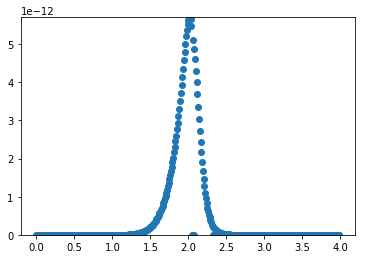

q: 2.02


In [19]:
gtruthS = np.asarray((dataBach, dataSpeech)) 
X, gtruthA = simpleMixer(gtruthS)
A, S = bss(X)

S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrackA_2.wav', 22050, S[0])
wavfile.write('data/separatedTrackB_2.wav', 22050, S[1])

The resulting mixing matrix is fairly accurate, and is more than enough to audibly seperate the two sources.

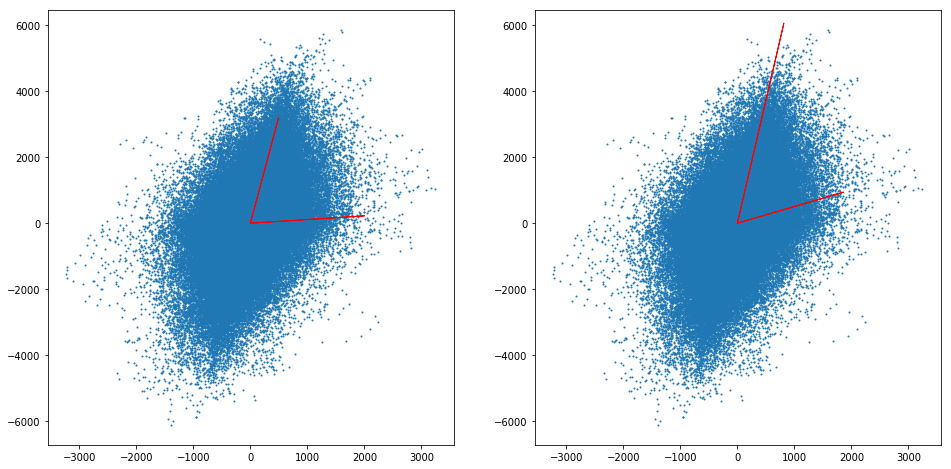

In [20]:
compareMixingMatrix(X, gtruthA, A)

#### Images

Since we have a method for estimating q, we can now apply BSS on unknown distributions with some accuracy.  Since the distribution of the pixel intensities is not known in two mixed images, this methodology should provide a mechanism seperating the mixture into two images.

In [21]:
import cv2
import matplotlib.pyplot as plt

img0 = cv2.imread('data/frame3.png', 0)
img1 = cv2.imread('data/frame7.png', 0)

img0_vec = np.ravel(img0/img0.max())
img1_vec = np.ravel(img1/img1.max())

img0_vec -= np.mean(img0_vec)
img1_vec -= np.mean(img1_vec)

In [22]:
gtruthI = np.asarray([img0_vec, img1_vec])

In [23]:
I, ItruthA  = simpleMixer(gtruthI)

As with before, we can plot the distribution and it's corresponding true mixing matrix.

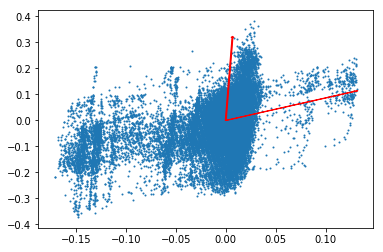

In [24]:
drawDataWithMixingMatrix(I, ItruthA)

Next, we will estimate the optimal distribution and find it's corresponding `q`.

q 0.01 log_likelihood -2.009384441099722e-78
q 0.02 log_likelihood 2.875362456475919e-79
q 0.03 log_likelihood 4.388537341566271e-114
q 0.04 log_likelihood -3.083071207724343e-90
q 0.05 log_likelihood -2.011110262385882e-87
q 0.060000000000000005 log_likelihood -1.1065836115065773e-82
q 0.06999999999999999 log_likelihood 7.378012218713036e-84
q 0.08 log_likelihood -1.2745103825521929e-70
q 0.09 log_likelihood -5.258967985847177e-67
q 0.09999999999999999 log_likelihood -5.301595538168459e-80
q 0.11 log_likelihood 4.0888153465552774e-52
q 0.12 log_likelihood 5.100662590063717e-54
q 0.13 log_likelihood -7.869118402405508e-62
q 0.14 log_likelihood 6.20070801053891e-53
q 0.15000000000000002 log_likelihood 2.1585057553271446e-59
q 0.16 log_likelihood 8.086773972417815e-51
q 0.17 log_likelihood -3.1100554910483108e-61
q 0.18000000000000002 log_likelihood 2.681389371882924e-52
q 0.19 log_likelihood 3.4111058919502024e-40
q 0.2 log_likelihood 3.481782018332539e-36
q 0.21000000000000002 log_like

q 1.75 log_likelihood 0.0007952381670342352
q 1.76 log_likelihood 0.0008454529240936062
q 1.77 log_likelihood 0.0008981951008467646
q 1.78 log_likelihood 0.0009535570371073872
q 1.79 log_likelihood 0.0010116329960595087
q 1.8 log_likelihood 0.0010725184064169372
q 1.81 log_likelihood 0.0011363113540960152
q 1.82 log_likelihood 0.0012031117803239745
q 1.83 log_likelihood 0.001273021190311711
q 1.84 log_likelihood 0.0013461433938732274
q 1.85 log_likelihood 0.0014225841995088276
q 1.86 log_likelihood 0.0015024513465623926
q 1.87 log_likelihood 0.0015858544505807667
q 1.8800000000000001 log_likelihood 0.0016729054511107047
q 1.8900000000000001 log_likelihood 0.0017637181386292661
q 1.9000000000000001 log_likelihood 0.0018584084906581094
q 1.9100000000000001 log_likelihood 0.001957094526947556
q 1.9200000000000002 log_likelihood 0.002059896372649186
q 1.93 log_likelihood 0.002166936150233712
q 1.94 log_likelihood 0.0022783380390224177
q 1.95 log_likelihood 0.002394228258769705
q 1.96 log_l

q 3.52 log_likelihood 0.18169517140093602
q 3.53 log_likelihood 0.18436275489691756
q 3.54 log_likelihood 0.187046865321696
q 3.55 log_likelihood 0.1897467790017067
q 3.56 log_likelihood 0.19246171773644935
q 3.57 log_likelihood 0.1951908487692425
q 3.58 log_likelihood 0.19793328550450684
q 3.59 log_likelihood 0.2006880890947898
q 3.5999999999999996 log_likelihood 0.20345427114065626
q 3.61 log_likelihood 0.20623079765568886
q 3.6199999999999997 log_likelihood 0.20901659455183025
q 3.63 log_likelihood 0.2118105549562218
q 3.6399999999999997 log_likelihood 0.21461154869448706
q 3.65 log_likelihood 0.21741843432554792
q 3.6599999999999997 log_likelihood 0.22023007423824226
q 3.67 log_likelihood 0.22304535324488964
q 3.6799999999999997 log_likelihood 0.22586320122979314
q 3.69 log_likelihood 0.22868262056496058
q 3.6999999999999997 log_likelihood 0.23150271899896427
q 3.71 log_likelihood 0.2343227488615156
q 3.7199999999999998 log_likelihood 0.23714215342743647
q 3.73 log_likelihood 0.239

q 5.41 log_likelihood 0.4926008344208675
q 5.42 log_likelihood 0.49814051084318695
q 5.43 log_likelihood 0.5048550802065611
q 5.4399999999999995 log_likelihood 0.5116575137227567
q 5.45 log_likelihood 0.5181736169701471
q 5.46 log_likelihood 0.5231169432167714
q 5.47 log_likelihood 0.5252058027330083
q 5.4799999999999995 log_likelihood 0.5260923032264726
q 5.49 log_likelihood 0.5282167727158578
q 5.5 log_likelihood 0.5301850402566225
q 5.51 log_likelihood 0.5300661297150885
q 5.52 log_likelihood 0.5302638851056443
q 5.53 log_likelihood 0.5332668732077677
q 5.54 log_likelihood 0.5328607656032193
q 5.55 log_likelihood 0.5134202205574268
q 5.56 log_likelihood 0.46952987636485044
q 5.57 log_likelihood 0.43289781591267035
q 5.58 log_likelihood 0.45168564532786687
q 5.59 log_likelihood 0.5420177745141631
q 5.6 log_likelihood 0.5643667860597351
q 5.61 log_likelihood 0.3880424542373348
q 5.62 log_likelihood 0.39684603709675886
q 5.63 log_likelihood 0.41708033469797284
q 5.64 log_likelihood 0.3

q 7.36 log_likelihood 3.71712849369512
q 7.37 log_likelihood 0.7862012238706867
q 7.38 log_likelihood 0.8906085884308445
q 7.39 log_likelihood 2.0433986821058716
q 7.4 log_likelihood 2.7489062136009164
q 7.41 log_likelihood 1.1304712955240186
q 7.42 log_likelihood 0.5409753665806061
q 7.43 log_likelihood 0.5595158817985164
q 7.4399999999999995 log_likelihood 2.20908208417789
q 7.45 log_likelihood 3.0167520213527594
q 7.46 log_likelihood 1.6252051860549883
q 7.47 log_likelihood 0.5139037342488592
q 7.4799999999999995 log_likelihood 0.16541289219332045
q 7.49 log_likelihood 2.716099309075727
q 7.5 log_likelihood 0.9251529193748802
q 7.51 log_likelihood 1.258452085006552
q 7.52 log_likelihood 0.3365856842556533
q 7.53 log_likelihood 0.3328810584350865
q 7.54 log_likelihood 3.1012457545201846
q 7.55 log_likelihood 1.6482335718224554
q 7.56 log_likelihood 3.4627785222045917
q 7.57 log_likelihood 3.2086901192435344
q 7.58 log_likelihood 0.8746959922659402
q 7.59 log_likelihood 2.592831424133

q 9.37 log_likelihood 0.1494014035329303
q 9.38 log_likelihood 0.33288232038567755
q 9.39 log_likelihood 4.477938561129752
q 9.4 log_likelihood 0.5841365580895339
q 9.41 log_likelihood 0.7504681228048056
q 9.42 log_likelihood 2.8477634220283474
q 9.43 log_likelihood 0.9646306078842393
q 9.44 log_likelihood 7.119064419695178
q 9.45 log_likelihood 3.8827345914854945
q 9.46 log_likelihood 0.678221540082958
q 9.47 log_likelihood 0.3208574840869436
q 9.48 log_likelihood 0.7028818261758738
q 9.49 log_likelihood 0.08360507210408276
q 9.5 log_likelihood 0.22039751611159392
q 9.51 log_likelihood 0.7830892116134766
q 9.52 log_likelihood 3.5154670350751376
q 9.53 log_likelihood 3.800822404875964
q 9.54 log_likelihood 7.39869120960396
q 9.55 log_likelihood 2.9234520548963294
q 9.56 log_likelihood 0.6960147761163366
q 9.57 log_likelihood 3.765783293831245
q 9.58 log_likelihood 1.6854176486280135
q 9.59 log_likelihood 0.3263879557359406
q 9.6 log_likelihood 0.5494100243276768
q 9.61 log_likelihood 3

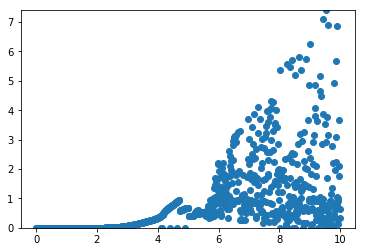

q: 9.52


In [25]:
IestimateA, recoverI = bss(I, q_max = 10)

The result is somewhat close to the original mixing matrix, especially given the lack of any information about the distribution.  The image distributions are inheritly multi-modal, which is poorly represented by a generalized gaussian.  Even so, the algorithm is able to provide a fairly good estimate.

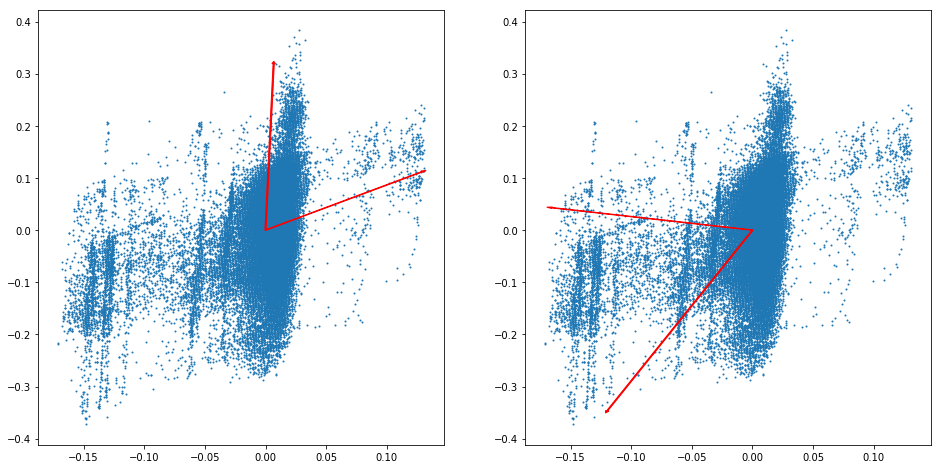

In [26]:
compareMixingMatrix(I, ItruthA, IestimateA)

In [27]:
def img_reshape(img):
    return np.reshape(img, (256, 256))

Note that the reconstructed images may be inverted for the same reason that the vectors are flipped.  However, the stucture of the image and the differences between the intensities are kept.

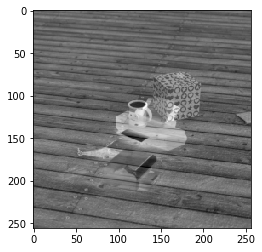

In [28]:
plt.imshow(img_reshape(recoverI[0]), cmap='gray')
plt.show()

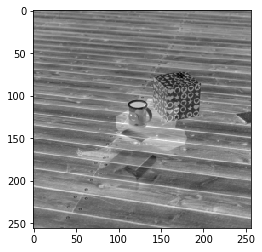

In [29]:
plt.imshow(img_reshape(recoverI[1]), cmap='gray')
plt.show()

### Conclusion
This project provided a lot of insight on Blind Source Separation, the application of ICA is very broad and can be extrapolated to a variety of modelling problems with varying success.  ICA appears to be limited to the availability of a prior, which can be found via a learning algorithm.  A basic implementation of such a learning algorithm was implemented here.